In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/comp642-project
%mkdir -p v2
%cd v2

Mounted at /content/drive
/content/drive/MyDrive/comp642-project
/content/drive/MyDrive/comp642-project/v2


In [ ]:
!nvidia-smi

Wed Apr 24 22:39:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              47W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
import time

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Data Preprocessing

In [ ]:
# Using small dataset for now
TRAIN_END_DATE = 424
TEST_END_DATE = 481
df = pd.read_csv('../data/train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int64  
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
 15  time_id                  int64  
 16  row_id                   object 
dtypes: float64(11), int64(5), object(1)
memory usage: 679.4+ MB


In [ ]:
# Checking missing values
# Far price and near price have a lot of missing values, because this data is only available for last 5 minutes.
df.isna().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64

## Split into train and test data

In [ ]:
train_df = df[df['date_id'] <= TRAIN_END_DATE]
test_df = df[(df['date_id'] > TRAIN_END_DATE) & (df['date_id'] <= TEST_END_DATE)]
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
del df

# Two-step Prediction (WAP -> Target)

### Set up for predicting wap_{t+60}

In [ ]:
# Adding our target wap_{t+60} to train and test data
train_df = train_df.sort_values(by=["stock_id", "date_id", "seconds_in_bucket"])
train_df['wap_t+60'] = train_df.groupby('stock_id')['wap'].shift(-6)

# The last 6 rows has NaN value for wap_{t+60}, so we will drop it
def delete_last_6_rows(group):
    return group.drop(group.tail(6).index)
train_df = train_df.groupby('stock_id').apply(delete_last_6_rows).reset_index(drop=True)

# Same for test data
test_df = test_df.sort_values(by=["stock_id", "date_id", "seconds_in_bucket"])
test_df['wap_t+60'] = test_df.groupby('stock_id')['wap'].shift(-6)
test_df = test_df.groupby('stock_id').apply(delete_last_6_rows).reset_index(drop=True)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id,wap_t+60
614789,199,480,390,0.00,0,1.001653,23764511.11,1.001653,1.001653,1.001494,160507.06,1.001812,93293.35,1.001695,4.080534,26439,480_390_199,1.001980
614790,199,480,400,0.00,0,1.001653,23764511.11,1.001653,1.001653,1.001494,188893.06,1.001812,88907.90,1.001710,3.299713,26440,480_400_199,1.001973
614791,199,480,410,0.00,0,1.001494,23764511.11,1.001494,1.001494,1.001494,239704.00,1.001812,117050.50,1.001708,4.470348,26441,480_410_199,1.001934
614792,199,480,420,0.00,0,1.001812,23777108.28,1.001812,1.001812,1.001812,219966.60,1.002129,87831.48,1.002039,0.180006,26442,480_420_199,1.001955
614793,199,480,430,0.00,0,1.001812,23777108.28,1.001812,1.001812,1.001812,172420.75,1.002129,119612.40,1.001999,1.430511,26443,480_430_199,1.001965
614794,199,480,440,0.00,0,1.001812,23777108.28,1.001812,1.001812,1.001812,176332.95,1.002129,113363.52,1.002005,8.859634,26444,480_440_199,1.002835
614795,199,480,450,0.00,0,1.001812,23777108.28,1.001812,1.001812,1.001812,218925.45,1.002129,194251.80,1.001980,9.020567,26445,480_450_199,1.002974
614796,199,480,460,135671.59,-1,1.001812,23784351.66,1.001177,1.001812,1.001812,233186.05,1.002129,226222.08,1.001973,0.849962,26446,480_460_199,1.001982
614797,199,480,470,796236.05,-1,1.001812,23788288.28,1.001177,1.001494,1.001812,245774.50,1.002129,394815.60,1.001934,0.760555,26447,480_470_199,1.001993
614798,199,480,480,1542650.27,-1,1.001812,23788288.28,1.000859,1.001494,1.001812,333420.40,1.002129,407092.44,1.001955,4.299879,26448,480_480_199,1.002274


In [ ]:
train_df = train_df.dropna(subset=['target', 'wap_t+60'])
test_df = test_df.dropna(subset=['target', 'wap_t+60'])

In [ ]:
# Getting features and target columns
featured_columns = ['imbalance_size', 'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
                    'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
                    'ask_size', 'wap']
target_column = 'wap_t+60'
X_train = train_df[featured_columns]
y_train = train_df[target_column]
X_test = test_df[featured_columns]
y_test = test_df[target_column]

## Baseline Model

In [ ]:
print("Baseline Model results")
baseline_pred = 0.999910 # mean of wap_t
train_baseline_mae = (baseline_pred - y_train).abs().mean()
test_baseline_mae = (baseline_pred - y_test).abs().mean()
train_baseline_mse = ((baseline_pred - y_train) ** 2).mean()
test_baseline_mse = ((baseline_pred - y_test) ** 2).mean()

print("Train MAE:", train_baseline_mae)
print("Train MSE:", train_baseline_mse)
print("Test MAE:", test_baseline_mae)
print("Test MSE:", test_baseline_mse)

Baseline Model results
Train MAE: 0.0017578050338829868
Train MSE: 6.480161552539416e-06
Test MAE: 0.0014116353008157864
Test MSE: 4.492761354553516e-06


## Random Forest Regressor

In [ ]:
start_time = time.time()
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train, y_train)
end_time = time.time()
print(f'Time taken to train Random Forest Regressor: {(end_time-start_time)/60} minutes')

In [ ]:
start_time = time.time()
y_pred_train = rf_regressor.predict(X_train)
y_pred_test = rf_regressor.predict(X_test)
end_time = time.time()
print(f'Inference time taken by Random Forest Regressor: {(end_time-start_time)/60} minutes')

mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print("Train Mean Absolute Error:", mae_train)
print("Train Mean Squared Error:", mse_train)
print("Train R2 Score:", r2_train)
print("Test Mean Absolute Error:", mae_test)
print("Test Mean Squared Error:", mse_test)
print("Test R2 Score:", r2_test)

Train Mean Absolute Error: 0.00022738427606324823
Train Mean Squared Error: 1.2057245911202418e-07
Train R2 Score: 0.9652567368081184
Test Mean Absolute Error: 0.001083217785601826
Test Mean Squared Error: 2.8356692128571456e-06
Test R2 Score: 0.7001323683961438


## XGBoost

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

start_time = time.time()
xgbRegressor = xgb.XGBRegressor()
xgbRegressor.fit(X_train, y_train)
end_time = time.time()
print(f'Time taken to train XGBRegressor: {(end_time-start_time)/60} minutes')

Time taken to train XGBRegressor: 0.12799001932144166 minutes


In [ ]:
start_time = time.time()
y_pred_train = xgbRegressor.predict(X_train)
y_pred_test = xgbRegressor.predict(X_test)
end_time = time.time()
print(f'Inference time taken by XGBoost: {(end_time-start_time)/60} minutes')

mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print("Train Mean Absolute Error:", mae_train)
print("Train Mean Squared Error:", mse_train)
print("Train R2 Score:", r2_train)
print("Test Mean Absolute Error:", mae_test)
print("Test Mean Squared Error:", mse_test)
print("Test R2 Score:", r2_test)

Inference time taken by Random Forest Regressor: 0.02216646671295166 minutes
Train Mean Absolute Error: 0.000920396084346452
Train Mean Squared Error: 1.794242668396468e-06
Train R2 Score: 0.7227438373723336
Test Mean Absolute Error: 0.000758082830716561
Test Mean Squared Error: 1.3674932646451703e-06
Test R2 Score: 0.6956210387456992


## Fine-tuning XGBoost

In [ ]:
import torch
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# X_train = X_train.fillna(0)
# X_test = X_test.fillna(0)
# X_train_gpu = torch.tensor(X_train.values).to('cuda')
# y_train_gpu = torch.tensor(y_train.values).to('cuda')

In [ ]:
param_space = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    # 'max_depth': [3, 5, 7, 10],
    # 'subsample': [0.4, 0.6, 0.8, 1],
    # 'colsample_bytree': [0.6, 0.8, 1.0],
    # 'gamma': [0, 0.1, 0.2],
    'n_estimators': [10, 50, 100, 200, 300]
}

torch.cuda.empty_cache()
xgb_gpu = xgb.XGBRegressor(device='cuda')
random_search = RandomizedSearchCV(estimator=xgb_gpu, param_distributions=param_space,
                                   n_iter=50, scoring='neg_mean_absolute_error', cv=3,
                                   verbose=1, n_jobs=-1, random_state=8)
# using data on gpu causes OutOfMemory: available 22.5 GB, needs 24 GB
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best Score:", -random_search.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 20 is smaller than n_iter=50. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters: {'n_estimators': 300, 'learning_rate': 0.1}
Best Score: 0.0009314302123133713


In [ ]:
xgb_best_model = random_search.best_estimator_
y_pred_test = xgb_best_model.predict(X_test)

mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
print("Test Mean Absolute Error:", mae_test)
print("Test Mean Squared Error:", mse_test)
print("Test R2 Score:", r2_test)

Test Mean Absolute Error: 0.000755259877147879
Test Mean Squared Error: 1.350335114165989e-06
Test R2 Score: 0.6994401288684234


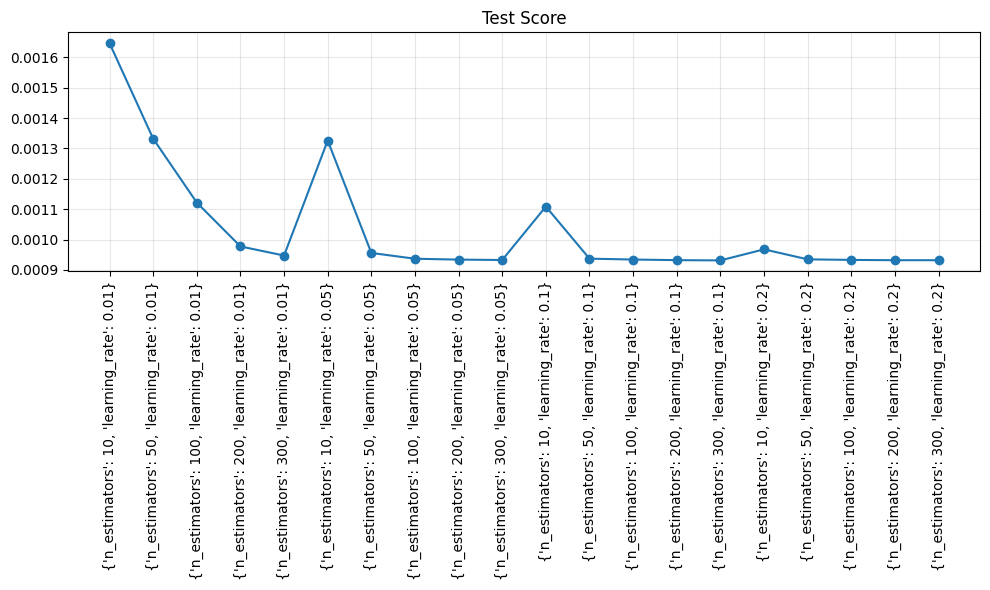

In [ ]:
results = random_search.cv_results_
mean_scores = random_search.cv_results_['mean_test_score']
plt.figure(figsize=(10, 6))
plt.plot(range(len(mean_scores)), -mean_scores, marker='o', linestyle='-')
plt.title('Test Score')
params = [str(m) for m in random_search.cv_results_['params']]
plt.xticks(range(len(mean_scores)), params, rotation=90)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Target Prediction

In [ ]:
# we need wap_{t+60} for all stocks
test_df['wap_t+60_pred'] = y_pred_test

WEIGHTS = np.loadtxt('../index_return_coef.csv', delimiter=',')[:, 1]
intercept = 9.657020388520454e-06

def compute_index(df, wap_column='wap_t+60_pred', index_column='index_wap'):
    for _, records  in tqdm(df.groupby(['date_id', 'seconds_in_bucket'])):
        curr_x = records[wap_column] / records['wap']
        if curr_x.size != 200:
            continue
        index_wap = np.dot(WEIGHTS, curr_x) + intercept
        df.loc[records.index, index_column] = [index_wap] * records.index.size

    return df

test_df = compute_index(test_df)
test_df["predicted_target"] = test_df["wap_t+60_pred"] / test_df["wap"] - test_df["index_wap"]
test_df = test_df.dropna(subset=['predicted_target', 'target'])

mae_test = mean_absolute_error(test_df["target"], test_df["predicted_target"])
mse_test = mean_squared_error(test_df["target"], test_df["predicted_target"])
r2_score_test = r2_score(test_df["target"], test_df["predicted_target"])

print("Test Mean Absolute Error:", mae_test)
print("Test Mean Squared Error:", mse_test)
print("Test R2 Score:", r2_score_test)

100%|██████████| 3074/3074 [00:01<00:00, 1634.10it/s]


Test Mean Absolute Error: 5.8472744375779
Test Mean Squared Error: 76.12898987478599
Test R2 Score: -2.7221602767468767e-05


# Direct Prediction

## XGBoost

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

featured_columns = ['imbalance_size', 'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
                    'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
                    'ask_size', 'wap']
target_column = 'target'
X_train = train_df[featured_columns]
y_train = train_df[target_column]
X_test = test_df[featured_columns]
y_test = test_df[target_column]


start_time = time.time()
xgbRegressor = xgb.XGBRegressor()
xgbRegressor.fit(X_train, y_train)
end_time = time.time()
print(f'Time taken to train XGBRegressor: {(end_time-start_time)/60} minutes')

Time taken to train XGBRegressor: 0.2519744316736857 minutes


In [ ]:
start_time = time.time()
y_pred_train = xgbRegressor.predict(X_train)
y_pred_test = xgbRegressor.predict(X_test)
end_time = time.time()
print(f'Inference time taken by XGBoost: {(end_time-start_time)/60} minutes')

mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print("Train Mean Absolute Error:", mae_train)
print("Train Mean Squared Error:", mse_train)
print("Train R2 Score:", r2_train)
print("Test Mean Absolute Error:", mae_test)
print("Test Mean Squared Error:", mse_test)
print("Test R2 Score:", r2_test)

Inference time taken by XGBoost: 0.02345555623372396 minutes
Train Mean Absolute Error: 6.336832749179623
Train Mean Squared Error: 85.32365026235183
Train R2 Score: 0.0635772455695135
Test Mean Absolute Error: 5.8180043931705905
Test Mean Squared Error: 76.1538616628539
Test R2 Score: -4.144106395687075e-05


## Tuning XGBoost

In [ ]:
import torch

param_space = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [5, 7, 10, None],
    'subsample': [0.6, 0.8, 1],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0.1, 0.2],
    'n_estimators': [50, 100, 200, 300]
}

torch.cuda.empty_cache()

start_time = time.time()
xgb_gpu = xgb.XGBRegressor(device='cuda')
random_search = RandomizedSearchCV(estimator=xgb_gpu, param_distributions=param_space,
                                   n_iter=50, scoring='neg_mean_absolute_error', cv=3,
                                   verbose=1, n_jobs=-1, random_state=8)
# using data on gpu causes OutOfMemory: available 22.5 GB, needs 24 GB
random_search.fit(X_train, y_train)

end_time = time.time()
print(f'Time taken to fine-tine XGBRegressor: {(end_time-start_time)/60} minutes')

print("Best Parameters:", random_search.best_params_)
print("Best Score:", -random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Time taken to fine-tine XGBRegressor: 6.464599863688151 minutes
Best Parameters: {'subsample': 1, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 1.0}
Best Score: 6.393966304041025


In [ ]:
xgb_best_model = random_search.best_estimator_
y_pred_test = xgb_best_model.predict(X_test)

mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
print("Test Mean Absolute Error:", mae_test)
print("Test Mean Squared Error:", mse_test)
print("Test R2 Score:", r2_test)

Test Mean Absolute Error: 5.79754806602575
Test Mean Squared Error: 75.126807112687
Test R2 Score: 0.013445689988534237


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [22:23:07] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


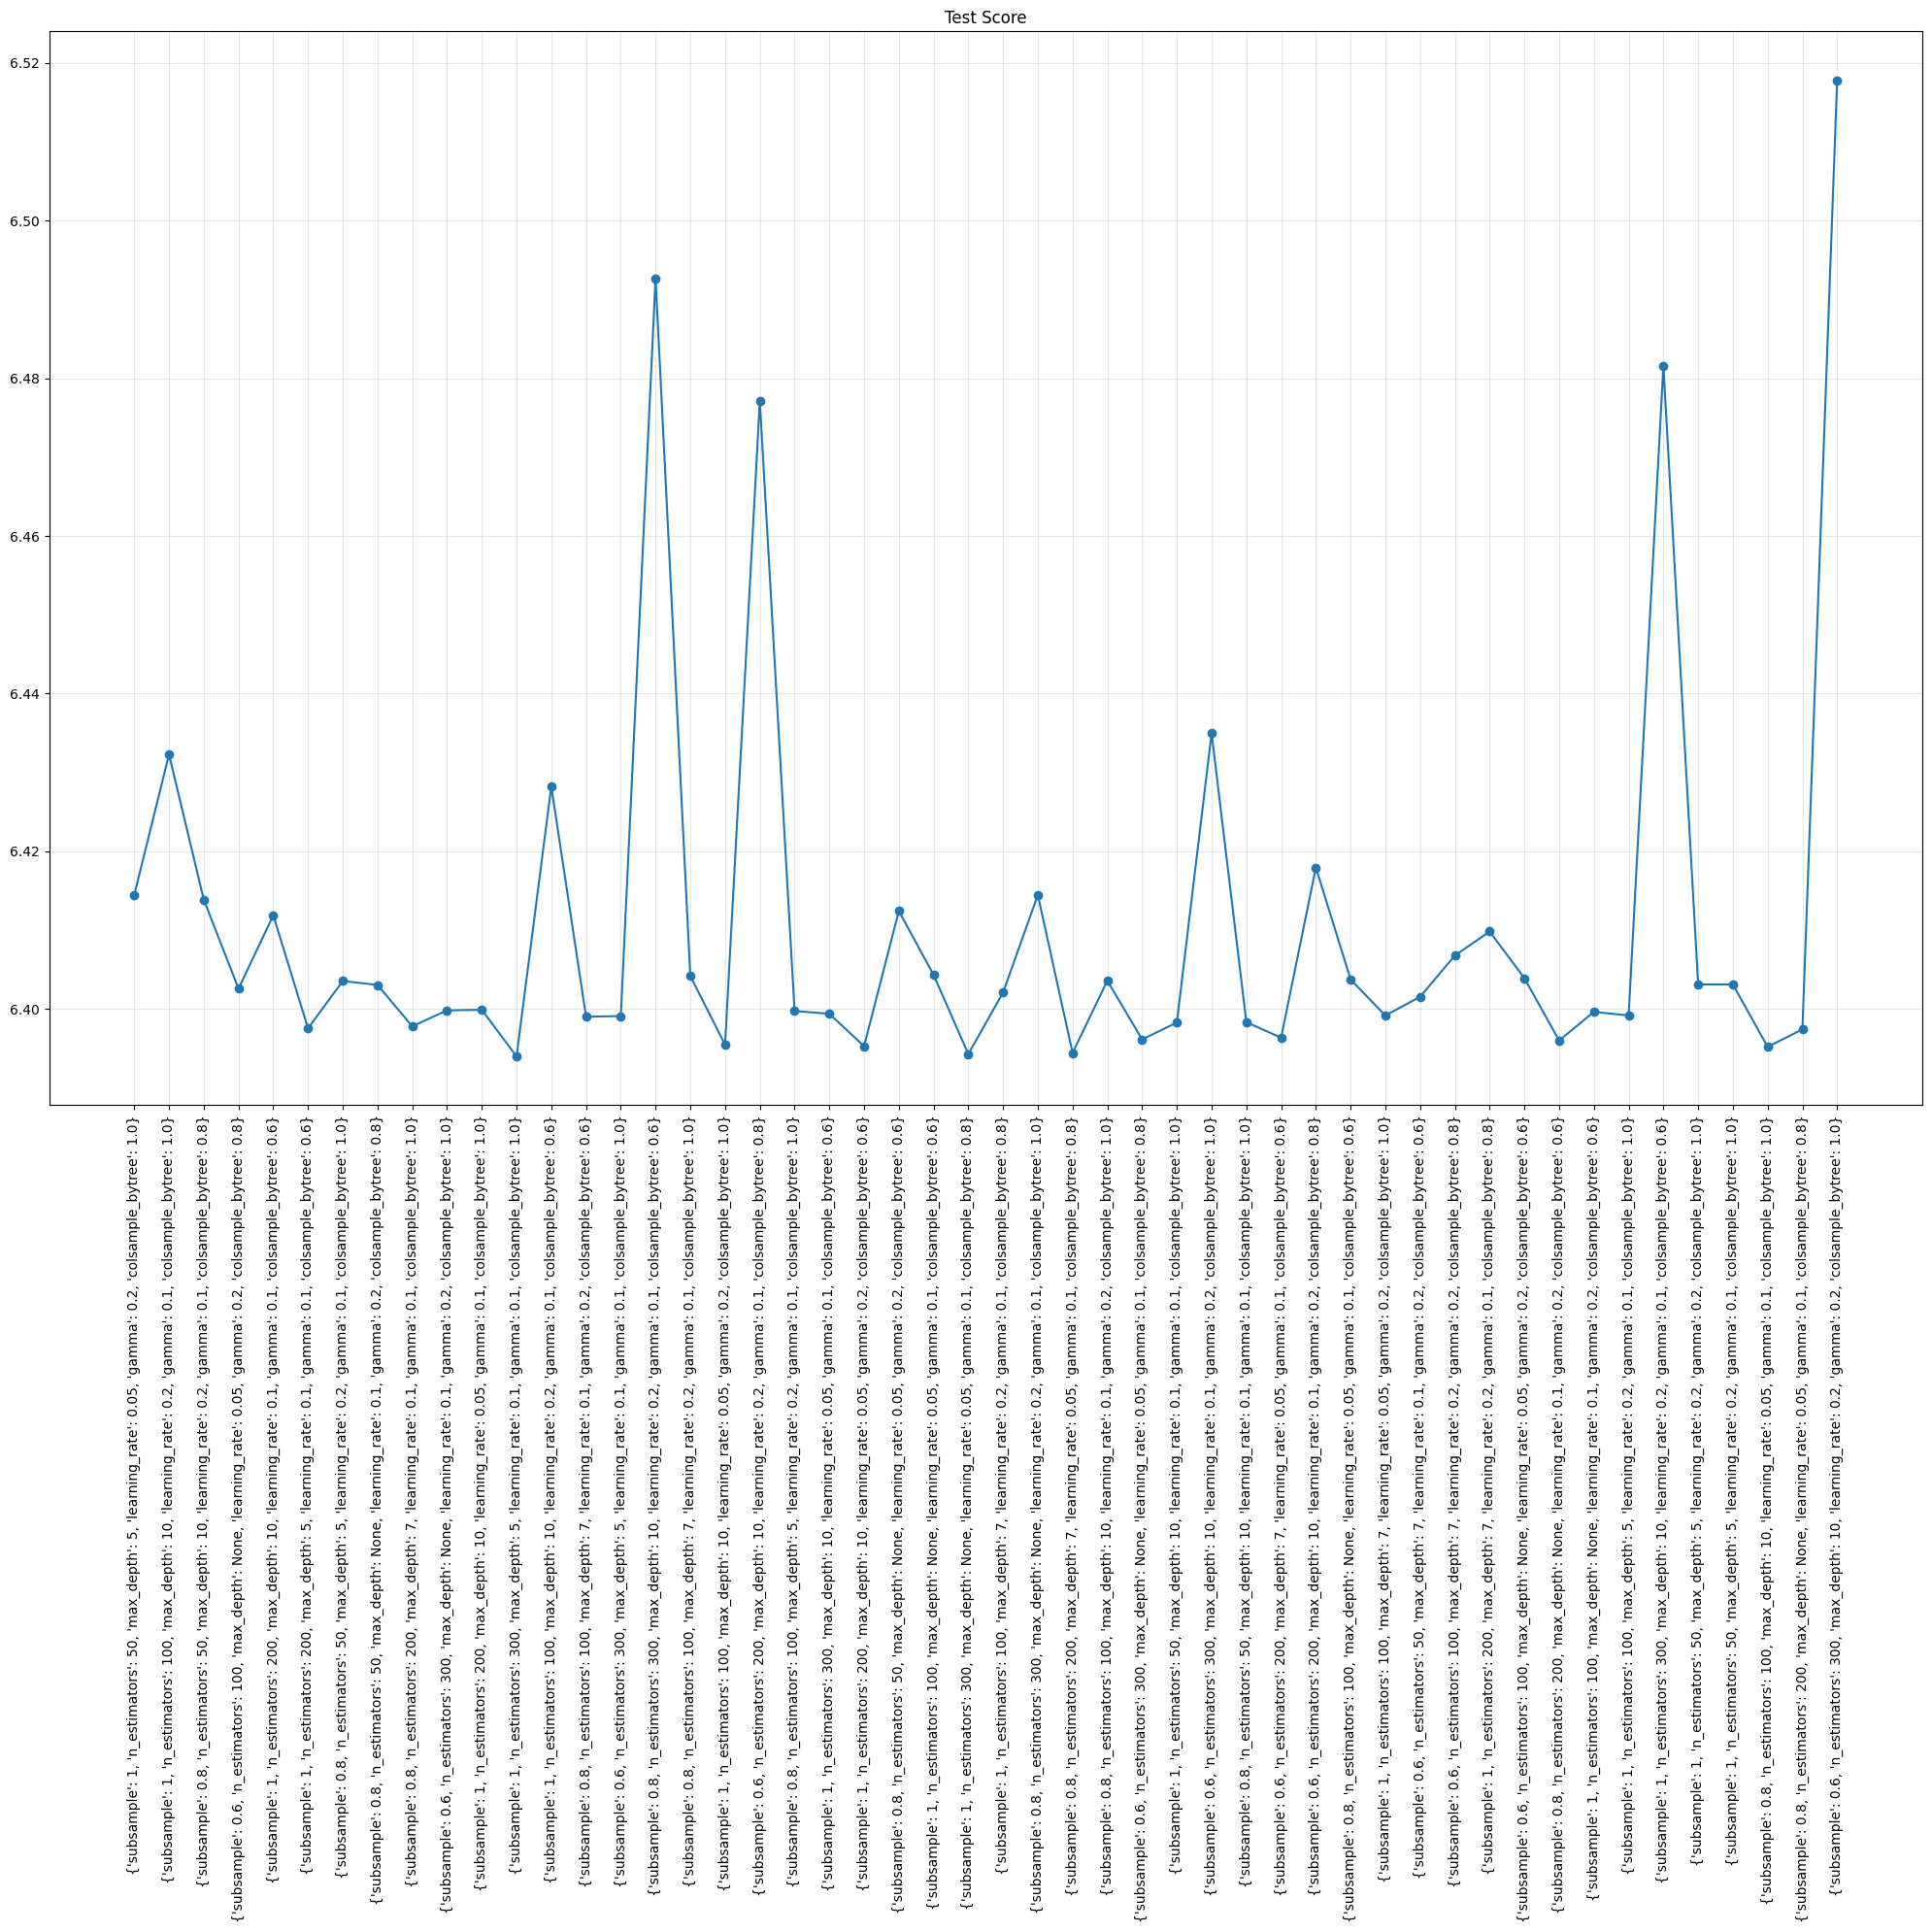

In [ ]:
results = random_search.cv_results_
mean_scores = random_search.cv_results_['mean_test_score']
plt.figure(figsize=(20, 20))
plt.plot(range(len(mean_scores)), -mean_scores, marker='o', linestyle='-')
plt.title('Test Score')
params = [str(m) for m in random_search.cv_results_['params']]
plt.xticks(range(len(mean_scores)), params, rotation=90)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
xgb_best_model = random_search.best_estimator_
y_pred_train = xgb_best_model.predict(X_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
print("Train Mean Absolute Error:", mae_train)
print("Train Mean Squared Error:", mse_train)
print("Train R2 Score:", r2_train)

Train Mean Absolute Error: 6.353938067824539
Train Mean Squared Error: 86.47786666118944
Train R2 Score: 0.05090977885793935


## Lagged features

In [ ]:
def add_features(df):
  for i in range(1, 5):
    df[f'imbalance_size_lag_{i}'] = df.groupby('stock_id')['imbalance_size'].shift(i)
    df[f'reference_price_lag_{i}'] = df.groupby('stock_id')['reference_price'].shift(i)
    df[f'matched_size_lag_{i}'] = df.groupby('stock_id')['matched_size'].shift(i)
    df[f'bid_price_lag_{i}'] = df.groupby('stock_id')['bid_price'].shift(i)
    df[f'ask_price_lag_{i}'] = df.groupby('stock_id')['ask_price'].shift(i)
    df[f'wap_{i}'] = df.groupby('stock_id')['wap'].shift(i)

  df['bid_size_lag_1'] = df.groupby('stock_id')['bid_size'].shift(1)
  df['ask_size_lag_1'] = df.groupby('stock_id')['ask_size'].shift(1)

  return df

train_df = add_features(train_df)
test_df = add_features(test_df)

In [ ]:
train_df.columns

Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target', 'time_id', 'row_id',
       'imbalance_size_lag_1', 'reference_price_lag_1', 'matched_size_lag_1',
       'bid_price_lag_1', 'ask_price_lag_1', 'wap_1', 'imbalance_size_lag_2',
       'reference_price_lag_2', 'matched_size_lag_2', 'bid_price_lag_2',
       'ask_price_lag_2', 'wap_2', 'imbalance_size_lag_3',
       'reference_price_lag_3', 'matched_size_lag_3', 'bid_price_lag_3',
       'ask_price_lag_3', 'wap_3', 'imbalance_size_lag_4',
       'reference_price_lag_4', 'matched_size_lag_4', 'bid_price_lag_4',
       'ask_price_lag_4', 'wap_4', 'bid_size_lag_1', 'ask_size_lag_1'],
      dtype='object')

In [ ]:
featured_columns = ['imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap',
       'imbalance_size_lag_1', 'reference_price_lag_1', 'matched_size_lag_1',
       'bid_price_lag_1', 'ask_price_lag_1', 'wap_1', 'imbalance_size_lag_2',
       'reference_price_lag_2', 'matched_size_lag_2', 'bid_price_lag_2',
       'ask_price_lag_2', 'wap_2', 'imbalance_size_lag_3',
       'reference_price_lag_3', 'matched_size_lag_3', 'bid_price_lag_3',
       'ask_price_lag_3', 'wap_3', 'imbalance_size_lag_4',
       'reference_price_lag_4', 'matched_size_lag_4', 'bid_price_lag_4',
       'ask_price_lag_4', 'wap_4', 'bid_size_lag_1', 'ask_size_lag_1']
target_column = 'target'
X_train = train_df[featured_columns]
y_train = train_df[target_column]
X_test = test_df[featured_columns]
y_test = test_df[target_column]

In [ ]:
# Best Parameters: {'subsample': 1, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 1.0}

start_time = time.time()
xgbRegressor = xgb.XGBRegressor(n_estimators=300, learning_rate=0.1)
xgbRegressor.fit(X_train, y_train)
end_time = time.time()

In [ ]:
start_time = time.time()
y_pred_train = xgbRegressor.predict(X_train)
y_pred_test = xgbRegressor.predict(X_test)
end_time = time.time()
print(f'Inference time taken by XGBoost: {(end_time-start_time)/60} minutes')

mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print("Train Mean Absolute Error:", mae_train)
print("Train Mean Squared Error:", mse_train)
print("Train R2 Score:", r2_train)
print("Test Mean Absolute Error:", mae_test)
print("Test Mean Squared Error:", mse_test)
print("Test R2 Score:", r2_test)

Inference time taken by XGBoost: 0.09375255107879639 minutes
Train Mean Absolute Error: 6.320926991831818
Train Mean Squared Error: 84.2825888947898
Train R2 Score: 0.07500284152498538
Test Mean Absolute Error: 5.797689190756131
Test Mean Squared Error: 75.06164242871345
Test R2 Score: 0.01430142314565086


In [ ]:
import torch
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

param_space = {
    'learning_rate': [0.1, 0.2, 1, 10],
    'max_depth': [5, 7],
    'subsample': [0.6, 0.8, 1],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0.1, 0.2],
    'n_estimators': [100, 200, 300]
}

torch.cuda.empty_cache()

start_time = time.time()
xgb_gpu = xgb.XGBRegressor(device='cuda')
random_search = RandomizedSearchCV(estimator=xgb_gpu, param_distributions=param_space,
                                   n_iter=50, scoring='neg_mean_absolute_error', cv=3,
                                   verbose=1, n_jobs=-1, random_state=8)
# may cause OutOfMemory
random_search.fit(X_train, y_train)

end_time = time.time()
print(f'Time taken to fine-tine XGBRegressor: {(end_time-start_time)/60} minutes')

print("Best Parameters:", random_search.best_params_)
print("Best Score:", -random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Time taken to fine-tine XGBRegressor: 12.298071642716726 minutes
Best Parameters: {'subsample': 1, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 1.0}
Best Score: 6.393380178835433


In [ ]:
xgb_best_model = random_search.best_estimator_
y_pred_test = xgb_best_model.predict(X_test)

mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
print("Test Mean Absolute Error:", mae_test)
print("Test Mean Squared Error:", mse_test)
print("Test R2 Score:", r2_test)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [23:20:32] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Test Mean Absolute Error: 5.795017667437385
Test Mean Squared Error: 74.89253184130173
Test R2 Score: 0.01652215879636698


## CatBoost

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 16.2 MB/s eta 0:00:00


In [ ]:
import time
from catboost import CatBoostRegressor

start_time = time.time()
catboost_regressor = CatBoostRegressor(iterations=300, learning_rate=0.1)
catboost_regressor.fit(X_train, y_train, verbose=0)
end_time = time.time()

print(f'Time taken to train CatBoostRegressor: {(end_time - start_time) / 60} minutes')

Time taken to train CatBoostRegressor: 0.9675212462743124 minutes


In [ ]:
y_pred_train = catboost_regressor.predict(X_train)
y_pred_test = catboost_regressor.predict(X_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print("Train Mean Absolute Error:", mae_train)
print("Train Mean Squared Error:", mse_train)
print("Train R2 Score:", r2_train)
print("Test Mean Absolute Error:", mae_test)
print("Test Mean Squared Error:", mse_test)
print("Test R2 Score:", r2_test)

Train Mean Absolute Error: 6.368024658284261
Train Mean Squared Error: 87.31490292147379
Train R2 Score: 0.041723348155506934
Test Mean Absolute Error: 5.793641841086204
Test Mean Squared Error: 74.99998050548342
Test R2 Score: 0.015111158557871263


# Baseline

In [ ]:
train_df = train_df.dropna(subset=['target'])
test_df = test_df.dropna(subset=['target'])

In [ ]:
print("Baseline 0 Model results")
baseline_pred = 0.0
train_baseline_mae = (baseline_pred - train_df["target"]).abs().mean()
train_baseline_mse = ((baseline_pred - train_df["target"]) ** 2).mean()
test_baseline_mae = (baseline_pred - test_df["target"]).abs().mean()
test_baseline_mse = ((baseline_pred - test_df["target"]) ** 2).mean()
test_baseline_r2 = r2_score([baseline_pred] * len(test_df), test_df["target"])


print("Train MAE:", train_baseline_mae)
print("Train MSE:", train_baseline_mse)
print("Test MAE:", test_baseline_mae)
print("Test MSE:", test_baseline_mse)
print("Test R2:", test_baseline_r2)

Baseline 0 Model results
Train MAE: 6.4821212887954465
Train MSE: 91.11882657167013
Test MAE: 5.8499123043254375
Test MSE: 76.15318142051221
Test R2: 0.0


In [ ]:
simple_mapping = {
                1: 0.1,
                0: 0,
                -1: -0.1}
test_df['baseline_1'] = test_df['imbalance_buy_sell_flag'].map(simple_mapping)
print("Baseline 1 Model results")
test_baseline_mae = mean_absolute_error(test_df['baseline_1'], test_df["target"])
test_baseline_mse = mean_squared_error(test_df['baseline_1'], test_df["target"])
test_baseline_r2 = r2_score(test_df['baseline_1'], test_df["target"])

print("Test MAE:", test_baseline_mae)
print("Test MSE:", test_baseline_mse)
print("Test R2:", test_baseline_r2)

Baseline 1 Model results
Test MAE: 5.8499749700259205
Test MSE: 76.15342693583447
Test R2: -9100.559741067376


# Results

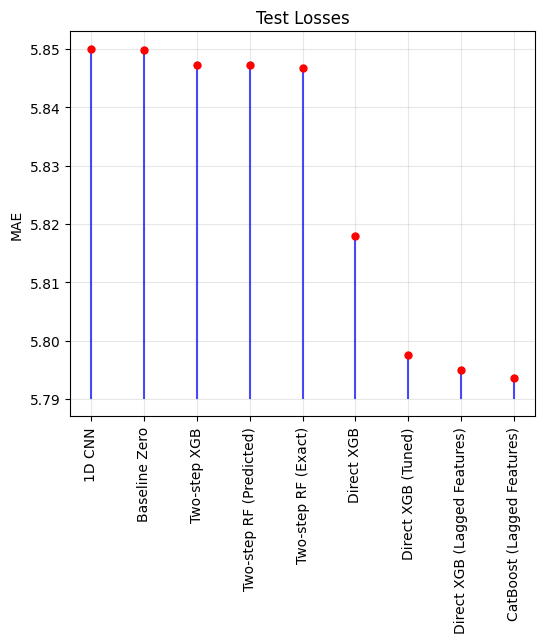

In [17]:
# Test Losses so far
def plot_latest_results(save=False):
  baseline_zero_prediction = 5.8499123043254375
  two_step_index_prediction_rf_wap_exact = 5.846767206098662
  two_step_index_prediction_rf_wap_predicted = 5.8472741657781535
  two_step_index_prediction_xgb = 5.8472744375779
  direct_index_prediction_xgb = 5.8180043931705905
  direct_index_prediction_xgb_tuned = 5.79754806602575
  direct_index_prediction_xgb_tunes_past_features = 5.795017667437385
  cat_boost_past_features = 5.793641841086204
  one_d_cnn = 5.850025976086137

  models = ['Baseline Zero', 'Two-step RF (Exact)', 'Two-step RF (Predicted)',
            'Two-step XGB', 'Direct XGB', 'Direct XGB (Tuned)', 'Direct XGB (Lagged Features)',
            'CatBoost (Lagged Features)', '1D CNN']
  test_losses = [baseline_zero_prediction, two_step_index_prediction_rf_wap_exact,
                two_step_index_prediction_rf_wap_predicted, two_step_index_prediction_xgb,
                direct_index_prediction_xgb, direct_index_prediction_xgb_tuned,
                direct_index_prediction_xgb_tunes_past_features, cat_boost_past_features, one_d_cnn]

  sorted_data = sorted(zip(models, test_losses), key=lambda x: -x[1])
  models_sorted, test_losses_sorted = zip(*sorted_data)

  plt.figure(figsize=(6, 5))
  plt.vlines(range(len(models_sorted)), ymin=5.79, ymax=test_losses_sorted, color='blue',
            alpha=0.7)
  plt.plot(range(len(models_sorted)), test_losses_sorted, 'o', color='red', markersize=5)
  plt.xticks(range(len(models_sorted)), models_sorted, rotation=90)
  plt.grid(True, alpha=0.3)
  plt.ylabel('MAE')

  plt.title('Test Losses')
  if save:
    plt.savefig("curr_losses.svg")
  plt.show()

plot_latest_results()

In [16]:
!ls

curr_losses.svg  sample_data
